## Magnet optimization

In [1]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
Br = 1.43 # (T) Residual flux density for N42
mu_0 = 4 * np.pi * 10**-7 # (H/m) Permeability of free space
l = 2.5e-2 # (m) Length of cube magnet
Volume = l ** 3 # (m^3)
moment = Br * Volume / mu_0 # (A m^2)
j = Br / mu_0 # (A/m)

In [3]:
Volume = 2.0e-3 ** 3
moment_target = Br * Volume / mu_0

In [4]:
target = np.array([0, 0, 0.3]) # target position is at 40 cm above the origin
workspace_length = 0.2 # workspace is a cube of 20 cm side length
mt = np.array([moment_target, 0, 0])

In [5]:
# return the magnetic field generated by a magnet at position p and orientation r
def generate_random_pose() -> tuple[np.ndarray, np.ndarray]:
    # generate a random pose
    r = R.random()
    p = np.random.rand(3) * workspace_length
    return p, r.as_matrix()

In [6]:
def B(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 3) * ((3 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) @ dm_i)

def F(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return 3 * mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 4) \
    * np.dot(
      np.outer(dm_i, r_i_hat) + 
      np.outer(r_i_hat, dm_i) - 
      ((5 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) * np.dot(dm_i, r_i_hat))
      , mt)

def F2(p_i: np.ndarray, m_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return 3 * mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 4) \
    * np.dot(r_i_hat, mt) *  m_i + \
      np.dot(r_i_hat, m_i) *  mt + \
      (np.dot(m_i, mt) - 5 * np.dot(r_i_hat, m_i) * np.dot(r_i_hat, mt)) * r_i_hat

def Jb(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 3) * ((3 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) @ dm_i)

def Jf(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return 3 * mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 4) \
    * np.dot(
      np.outer(dm_i, r_i_hat) + 
      np.outer(r_i_hat, dm_i) - 
      ((5 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) * np.dot(dm_i, r_i_hat))
      , mt)

In [7]:
m = 20 # Number of random poses
K = 6 # Selection budget
d = 2 # Number of divisions for angles
n = d ** K

In [8]:
# Generating all combinations of angles
lins  = [np.linspace(0, 1.5*np.pi, d) for i in range(K)]
# lins.append(np.linspace(0, 2*np.pi, d) + np.pi/4)
angles = np.array(np.meshgrid(*lins)).T.reshape(-1, K)

In [9]:
# S is an array of tuples, each tuple contains a position and a rotation matrix
S = [generate_random_pose() for i in range(m)]

In [10]:
# computing Bmax, Fmax
Bmax = 0.
Fmax = 0.
for p, r in S:
  m_i = np.array([0, 0, moment])
  Bmax += (B(p, m_i)**2).sum()
  Fmax += (F(p, m_i)**2).sum()

In [11]:
# Initizaling A
A = np.zeros((n, K, m, 6, 6))

for t, theta in enumerate(angles):
  for i in range(K):
    for j, (p, r) in enumerate(S):
      dmagnetization = r.dot([- np.sin(theta[i]), np.cos(theta[i]), 0])
      J = np.concatenate([Jb(p, dmagnetization)/Bmax, Jf(p, dmagnetization)/Fmax]) 
      A[t, i, j, :, :] = np.outer(J, J)

In [12]:
# Initizaling f
f = np.zeros((n, K, m, 6, 6))

for t, theta in enumerate(angles):
  for i in range(K):
    for j, (p, r) in enumerate(S):
      magnetization = r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
      fj = np.concatenate([B(p, dmagnetization), F(p, magnetization)])
      f[t, i, j, :, :] = np.outer(fj, fj)

In [13]:
def A_operator(X, t):
  return sum([X[i][j] * A[t, i, j] for i in range(K) for j in range(m)])

def f_operator(X):
  return sum([X[i][j] * f[t, i, j] for t in range(n) for i in range(K) for j in range(m)])

In [14]:
X = cp.Variable(shape=(K, m))
t = cp.Variable(1)

alpha = 0
# obj = cp.Maximize(t + alpha * f_operator(X))
obj = cp.Maximize(t)
cons1 = X >= 0.0
cons2 = X <= 1.0
cons4 = cp.sum(X) == K # sum of all elements is K
cons5 = cp.sum(X, axis=1) == 1.0 # sum of each row is 1
cons6 = cp.sum(X, axis=0) <= 1.0 # sum of each col is le 1
constraints = [cons1, cons2, cons4, cons5, cons6]
for i in range(n):
  constraints.append(t <= cp.atoms.lambda_min(A_operator(X, i)))
prob = cp.Problem(obj, constraints)

In [15]:
prob.solve(verbose=True, solver=cp.CLARABEL)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 16 07:44:41 PM: Your problem has 121 variables, 331 constraints, and 0 parameters.
(CVXPY) Aug 16 07:44:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 16 07:44:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 16 07:44:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 16 07:44:42 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 16 07:44:42 PM: Compiling problem (target solver=CLARABEL

c:\Users\Veerash\MiniConda3\envs\magnetics\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0.012470283289065142

In [16]:
print("Status: ", prob.status)
print("Solution x = ", X.value)
print("Solution t = ", t.value)

Status:  optimal_inaccurate
Solution x =  [[7.61359675e-04 9.29707004e-08 8.29215427e-08 1.66711645e-01
  8.33322273e-08 6.88861323e-02 1.66664940e-01 1.29784610e-07
  6.05242706e-07 1.19087504e-01 4.65569466e-07 1.13809873e-01
  4.08159403e-02 1.66641907e-01 1.10713405e-01 8.20167233e-08
  1.04245517e-07 3.51521946e-02 1.07533788e-02 7.40319028e-08]
 [7.61363081e-04 9.29707096e-08 8.29215605e-08 1.66655909e-01
  8.33322003e-08 6.88942580e-02 1.66665253e-01 1.29784610e-07
  6.05245162e-07 1.19134249e-01 4.65569048e-07 1.13788834e-01
  4.08199812e-02 1.66667649e-01 1.10696439e-01 8.20167143e-08
  1.04245564e-07 3.51605416e-02 1.07538030e-02 7.40319103e-08]
 [7.61363449e-04 9.29707100e-08 8.29215515e-08 1.66661366e-01
  8.33322089e-08 6.88970459e-02 1.66668603e-01 1.29784595e-07
  6.05245145e-07 1.19123461e-01 4.65568996e-07 1.13782123e-01
  4.08190524e-02 1.66664054e-01 1.10709565e-01 8.20167154e-08
  1.04245548e-07 3.51578006e-02 1.07538458e-02 7.40319054e-08]
 [7.61363965e-04 9.297071

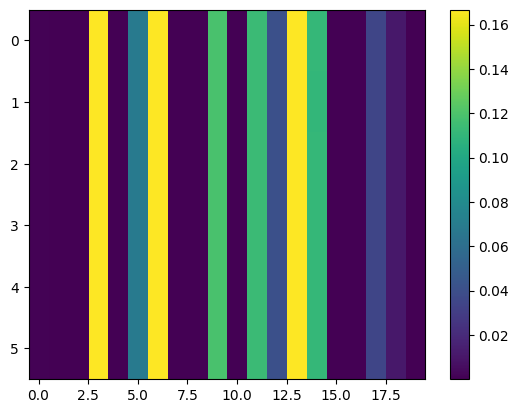

In [17]:
c = plt.imshow(X.value, aspect="auto")
plt.colorbar(c)
plt.show()

## Rounding

In [18]:
def top_k(soln, k):
  result = cp.sum(soln, axis=0)
  return np.argsort(result.value)[-k:]

In [19]:
inds = top_k(X, K)
print(inds)

[14 11  9  6 13  3]


## Saving and Loading data

In [ ]:
import pickle, random
dp = dict(S=S, X=X, t=t, params={"m": m, "K": K, "d": d, "n": n})

with open("runs/checkpoint_d5.pkl", "wb") as cp_file:
    pickle.dump(dp, cp_file)

In [ ]:
import pickle

dp = pickle.load(open("runs/checkpoint_m100d2k8_bigger_magnet.pkl", "rb"))
X, S, t = dp["X"], dp["S"], dp["t"]
K = 8

## Histogram of singular values

In [20]:
import scipy.sparse.linalg as sp
import matplotlib.pyplot as plt

In [21]:
singular_values = []
for theta in angles:
  J = np.zeros((6, 6))
  for i, ind in enumerate(inds):
    p, r = S[ind]
    magnetization = r.dot([-np.sin(theta[i]), np.cos(theta[i]), 0])
    Ji = np.concatenate([Jb(p, dmagnetization)/Bmax, Jf(p, dmagnetization)/Fmax])
    J[:, i] = Ji
  _, s, _ = sp.svds(J, k=1, which='SM')
  singular_values.append(s[0])
	  

In [ ]:
print(len(angles))

In [ ]:
print(len(singular_values))

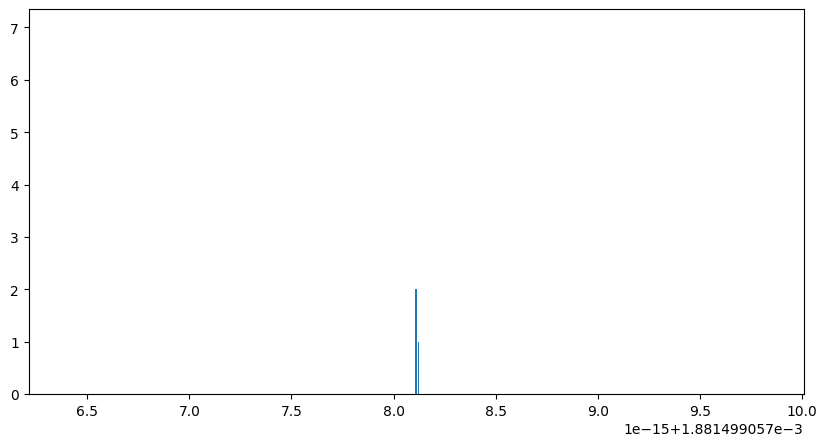

In [22]:
plt.hist(singular_values, bins=50)
plt.gcf().set_size_inches(10, 5)
plt.show()

## Evalulation

In [ ]:
from scipy.optimize import minimize

In [ ]:
force_x(np.random.rand(K) * 2*np.pi)

In [ ]:
def force_x(x):
  total_force_x = 0.
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([np.cos(x[i]), np.sin(x[i]), 0])
    total_force_x += np.abs(F(p, m_i)[0])
    # What to do for jac abs
  return -1. * total_force_x

def force_x_grad(x):
  jac = np.array([])
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([-np.sin(x[i]), np.cos(x[i]), 0])
    jac= np.append(abs(jac), Jf(p, m_i)[1])
  return jac
    

In [ ]:
x0 = np.random.rand(K) * 2*np.pi
print(x0)
bounds = [(0, 2 * np.pi)] * K
res = minimize(force_x, x0, method='CG', jac=force_x_grad,
               options={'gtol': 1e-6, 'disp': True})

In [ ]:
print(res.x)

In [ ]:
print(force_x(res.x))

## Testing Patrick's design

In [ ]:
# Magnet Positions (deg) Rotational Axes (deg)
#    α  φ    β  ξ
# 1 335 115 70 60
# 2 40 105 225 145
# 3 235 112 315 20
# 4 90 45 148 235
# 5 198 45 265 260
# 6 305 55 25 225
# 7 70 180 275 90
# 8 166 115 350 130
r = 0.075
spherical_magnet_positions = [[335, 115], [40, 105], [235, 112], [90, 45], [198, 45], [305, 55], [70, 180], [166, 115]]
spherical_rotational_axes = [[70, 60], [225, 145], [315, 20], [148, 235], [265, 260], [25, 225], [275, 90], [350, 130]]
cartesian_magnet_positions = [ [r * np.sin(np.deg2rad(theta)) * np.cos(np.deg2rad(phi)),
                                r * np.sin(np.deg2rad(theta)) * np.sin(np.deg2rad(phi)),
                                r * np.cos(np.deg2rad(theta))] 
                              for phi, theta in spherical_magnet_positions]
cartesian_rotational_axes = [ [np.sin(np.deg2rad(alpha)) * np.cos(np.deg2rad(beta)),
                               np.sin(np.deg2rad(alpha)) * np.sin(np.deg2rad(beta)),
                               np.cos(np.deg2rad(beta))] 
                             for beta, alpha in spherical_rotational_axes]

In [ ]:
import magpylib as magpy

coll = magpy.Collection()

for i in range(8):
    p = cartesian_magnet_positions[i]
    # print(p)
    r = R.from_rotvec(cartesian_rotational_axes[i])
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    theta = 1.57
    axis = r.as_matrix().dot([0, 1, 0])
    # print(r.dot([np.cos(theta), np.sin(theta), 0]))
    # coll.add(magpy.magnet.Sphere(magnetization=(J, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)))
    coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p, orientation=r, style_magnetization_mode='arrow').rotate_from_angax(np.linspace(0, 360, 30), axis=axis, start=0))
# coll[0].rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0)
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))
magpy.show(coll, animation=True)
# magpy.show(coll2)

## TESTING STUFF BELOW

In [ ]:
theta = 0.5
p = [np.cos(theta), np.sin(theta), 0]
r = R.random()
p1 = r.as_matrix().dot(p)
p_r, r_r = generate_random_pose()
print(Jb(p_r, p1))
print(Jf(p_r, p1))
np.concatenate([Jb(p_r, p1), Jf(p_r, p1)])

In [ ]:
x = cp.Variable(1)
t = cp.Variable(1)

obj = cp.Maximize(t)
cons1 = x >= 0.0
cons2 = x <= 10.0
cons3 = t <= -x
prob = cp.Problem(obj, [cons1, cons2, cons3])
prob.solve()

print("Status: ", prob.status)
print("Solution x = ", x.value)
print("Solution t = ", t.value)

In [ ]:
prob.solve()

print("Status: ", prob.status)
print("Solution x = ", x.value)
print("Solution t = ", t.value)

In [ ]:
test = cp.Constant(np.array([[1, 2, 3], [4, 5, 6]]))

In [ ]:
bl = cp.Constant(np.array([[1, 0, 1], [1, 0, 0]])) 
blsum = bl <= 1.0
blsum.value()

In [ ]:
cp.sum(test, 0).value

In [ ]:
theta = 0
p = [np.cos(theta), np.sin(theta), 0]

In [ ]:
def are_points_too_close(self, ind):
    for i in range(0, self.n * 2, 2):
        for j in range(i+2, self.n * 2, 2):
            dis = np.sqrt((ind[i] - ind[j])**2 + (ind[i+1] - ind[j+1])**2)
            if dis < self.min_distance:
                return True
    return False

## Visualization

In [ ]:
import magpylib as magpy

coll = magpy.Collection()

inds = top_k(X, K)

for i in inds:
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)).rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0))
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))

magpy.show(coll, animation=True)

## Testing visualization stuff

In [ ]:
r = R.random()
print(r.as_euler('ZYX', degrees=True))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# rotates around x, y

theta = 0.1
p = [np.cos(theta), np.sin(theta), 0]
xyz = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
# r = R.from_euler('ZYX', [45, 0, 90], degrees=True)
p1 = r.as_matrix().dot(p)
p2s = [np.concatenate(([0, 0, 0], r.as_matrix().dot(x))) for x in xyz]
print(p2s)
# soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
# p2s.append([0, 0, 0, p1[0], p1[1], p1[2]])
soa = np.array(p2s)

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, color='r')
soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
X, Y, Z, U, V, W = zip(*soa)
ax.quiver(X, Y, Z, U, V, W, color='b')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(30, 80) 
plt.show()

In [ ]:
import magpylib as magpy

coll = magpy.Collection()
coll2 = magpy.Collection()

for i in range(1):
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    theta = 1.57
    print(r.dot([np.cos(theta), np.sin(theta), 0]))
    # coll.add(magpy.magnet.Sphere(magnetization=(J, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)))
    coll.add(magpy.magnet.Sphere(magnetization=(J, 0, 0), diameter=l, position=p, orientation=R.from_matrix(r), style_magnetization_mode='arrow'))
    coll2.add(magpy.magnet.Sphere(magnetization=J*r.dot([np.cos(theta), np.sin(theta), 0]), diameter=l, position=p,  style_magnetization_mode='arrow'))
coll[0].rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0)
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))
magpy.show(coll, animation=True)
magpy.show(coll2)

In [ ]:
import numpy as np

In [ ]:
for i in range(100):
  print(127 + 127 * np.sin(2 * np.pi * i / 100), end=", ")